In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score

In [2]:
df = pd.read_csv("transport_demand_data.csv")

print("\nDATA PREVIEW")
print(df.head())


DATA PREVIEW
              Datetime Route_ID  Passenger_Count  Vehicle_Capacity Weather  \
0  2024-01-01 00:00:00       R7               48               120  Cloudy   
1  2024-01-01 01:00:00      R10               42               100  Cloudy   
2  2024-01-01 02:00:00       R6               21                60   Foggy   
3  2024-01-01 03:00:00       R1               41               120   Foggy   
4  2024-01-01 04:00:00      R10               47               120   Foggy   

  Day_Type  Fuel_Cost_Per_Trip Traffic_Level  
0  Weekend                5.89          High  
1  Weekend                4.83          High  
2  Weekend                4.35           Low  
3  Weekday                4.66          High  
4  Weekday                5.32          High  


In [3]:
# 2. DATA PREPROCESSING
# -----------------------------
df["Datetime"] = pd.to_datetime(df["Datetime"])
df["Hour"] = df["Datetime"].dt.hour
df["Day"] = df["Datetime"].dt.day_name()

# Vehicle utilization %
df["Utilization_%"] = (
    df["Passenger_Count"] / df["Vehicle_Capacity"]
) * 100

print("\nDATA INFO")
print(df.info())


DATA INFO
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Datetime            300 non-null    datetime64[ns]
 1   Route_ID            300 non-null    object        
 2   Passenger_Count     300 non-null    int64         
 3   Vehicle_Capacity    300 non-null    int64         
 4   Weather             300 non-null    object        
 5   Day_Type            300 non-null    object        
 6   Fuel_Cost_Per_Trip  300 non-null    float64       
 7   Traffic_Level       300 non-null    object        
 8   Hour                300 non-null    int32         
 9   Day                 300 non-null    object        
 10  Utilization_%       300 non-null    float64       
dtypes: datetime64[ns](1), float64(2), int32(1), int64(2), object(5)
memory usage: 24.7+ KB
None


In [4]:
# 3. BASIC STATISTICS
# -----------------------------
print("\nSUMMARY STATISTICS")
print(df.describe())

print("\nAVERAGE UTILIZATION:", df["Utilization_%"].mean())


SUMMARY STATISTICS
                  Datetime  Passenger_Count  Vehicle_Capacity  \
count                  300       300.000000        300.000000   
mean   2024-01-07 05:30:00        56.500000         89.800000   
min    2024-01-01 00:00:00        20.000000         60.000000   
25%    2024-01-04 02:45:00        38.000000         60.000000   
50%    2024-01-07 05:30:00        55.500000         80.000000   
75%    2024-01-10 08:15:00        70.000000        120.000000   
max    2024-01-13 11:00:00       116.000000        120.000000   
std                    NaN        22.753808         22.986691   

       Fuel_Cost_Per_Trip        Hour  Utilization_%  
count          300.000000  300.000000     300.000000  
mean             5.650367   11.260000      66.438056  
min              3.510000    0.000000      16.666667  
25%              4.667500    5.000000      41.666667  
50%              5.825000   11.000000      63.166667  
75%              6.615000   17.000000      91.437500  
max      

In [5]:
# 4. PEAK HOUR ANALYSIS
# -----------------------------
peak_hour = (
    df.groupby("Hour")["Passenger_Count"]
    .mean()
    .sort_values(ascending=False)
)

print("\nTOP PEAK HOURS")
print(peak_hour.head())

# -----------------------------
# 5. ROUTE PERFORMANCE
# -----------------------------
route_demand = df.groupby("Route_ID")["Passenger_Count"].mean()
print("\nAVERAGE DEMAND BY ROUTE")
print(route_demand.sort_values(ascending=False))



TOP PEAK HOURS
Hour
7     88.230769
17    85.583333
9     80.923077
19    80.916667
8     79.230769
Name: Passenger_Count, dtype: float64

AVERAGE DEMAND BY ROUTE
Route_ID
R4     63.733333
R10    61.464286
R5     60.523810
R8     59.533333
R2     56.789474
R3     55.028571
R9     54.214286
R1     53.976190
R6     52.300000
R7     45.666667
Name: Passenger_Count, dtype: float64


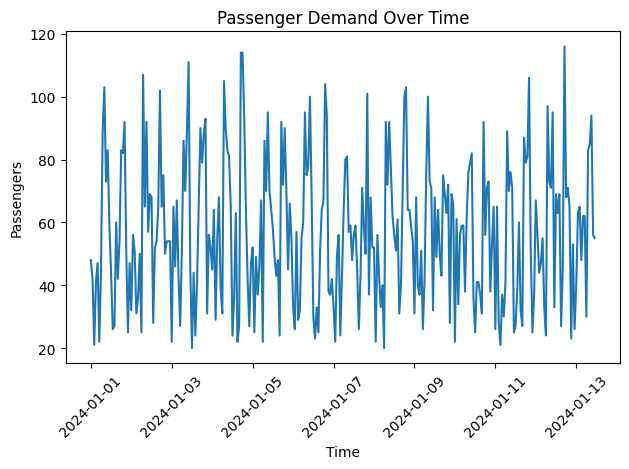

In [6]:
# 6. VISUALIZATIONS
# -----------------------------

# Demand trend over time
plt.figure()
plt.plot(df["Datetime"], df["Passenger_Count"])
plt.title("Passenger Demand Over Time")
plt.xlabel("Time")
plt.ylabel("Passengers")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

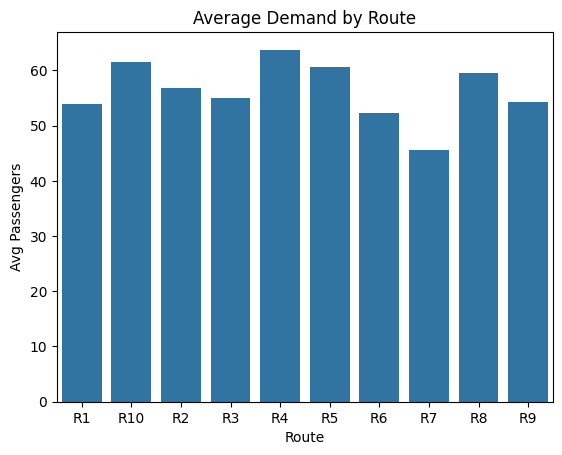

In [7]:
# Route demand comparison
plt.figure()
sns.barplot(x=route_demand.index, y=route_demand.values)
plt.title("Average Demand by Route")
plt.xlabel("Route")
plt.ylabel("Avg Passengers")
plt.show()

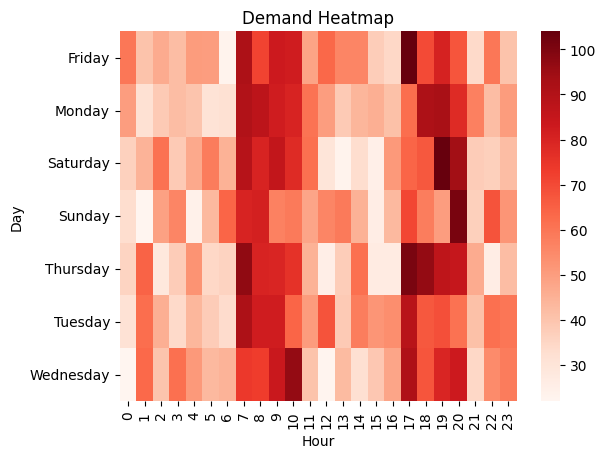

In [8]:
# Peak hour heatmap
pivot = df.pivot_table(
    values="Passenger_Count",
    index="Day",
    columns="Hour",
    aggfunc="mean"
)

plt.figure()
sns.heatmap(pivot, cmap="Reds")
plt.title("Demand Heatmap")
plt.show()

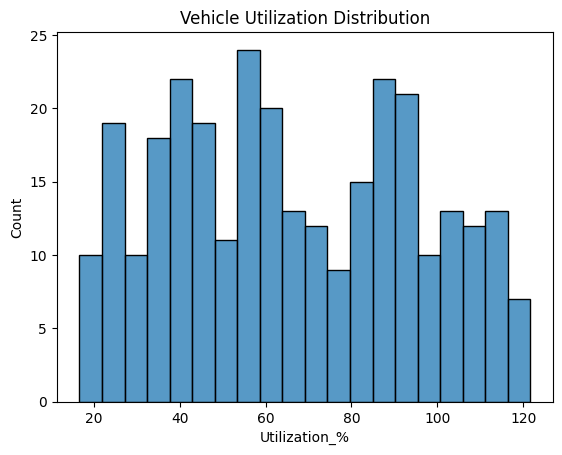

In [9]:
# Utilization distribution
plt.figure()
sns.histplot(df["Utilization_%"], bins=20)
plt.title("Vehicle Utilization Distribution")
plt.show()

In [10]:
# 7. MACHINE LEARNING FORECASTING
# -----------------------------

# Encode categorical variables
df_model = df.copy()
df_model = pd.get_dummies(
    df_model,
    columns=["Route_ID", "Weather", "Day_Type", "Traffic_Level"],
    drop_first=True
)

X = df_model.drop(
    ["Passenger_Count", "Datetime", "Day"],
    axis=1
)
y = df_model["Passenger_Count"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [11]:
# 8. MODEL COMPARISON
# -----------------------------
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor()
}

results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    pred = model.predict(X_test)

    mae = mean_absolute_error(y_test, pred)
    r2 = r2_score(y_test, pred)

    results.append([name, mae, r2])
    print(f"\n{name}")
    print("MAE:", mae)
    print("R2:", r2)

results_df = pd.DataFrame(
    results,
    columns=["Model", "MAE", "R2"]
)

print("\nMODEL COMPARISON")
print(results_df)



Linear Regression
MAE: 4.269507055109195
R2: 0.9400816339512335

Random Forest
MAE: 1.837333333333333
R2: 0.9775703375973839

MODEL COMPARISON
               Model       MAE        R2
0  Linear Regression  4.269507  0.940082
1      Random Forest  1.837333  0.977570


In [12]:
# 9. FUTURE DEMAND PREDICTION
# -----------------------------
best_model = RandomForestRegressor()
best_model.fit(X, y)

future_predictions = best_model.predict(X)

df["Predicted_Demand"] = future_predictions


In [13]:
# 10. EXPORT RESULTS FOR DASHBOARD
# -----------------------------
df.to_csv("transport_with_predictions.csv", index=False)

print("\nFile saved: transport_with_predictions.csv")


File saved: transport_with_predictions.csv



TOP DEMAND DRIVERS
                 Feature  Importance
3          Utilization_%    0.754296
0       Vehicle_Capacity    0.237534
1     Fuel_Cost_Per_Trip    0.001897
2                   Hour    0.001471
4           Route_ID_R10    0.000709
15         Weather_Rainy    0.000693
18  Traffic_Level_Medium    0.000527
13        Weather_Cloudy    0.000446
11           Route_ID_R8    0.000362
14         Weather_Foggy    0.000332


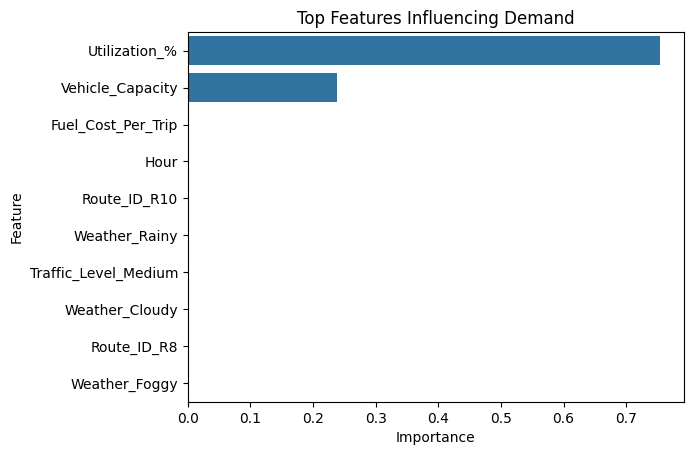


ANALYSIS COMPLETE


In [14]:
# 11. FEATURE IMPORTANCE
# -----------------------------
importances = best_model.feature_importances_
features = X.columns

importance_df = pd.DataFrame({
    "Feature": features,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

print("\nTOP DEMAND DRIVERS")
print(importance_df.head(10))

plt.figure()
sns.barplot(
    x="Importance",
    y="Feature",
    data=importance_df.head(10)
)
plt.title("Top Features Influencing Demand")
plt.show()

print("\nANALYSIS COMPLETE")